# Functional connectivity analysis of emotional music data based on univariate activation ROIs using nistats
Data set can be obtained from: https://openneuro.org/datasets/ds000171/versions/00001

Comparing the effect of emotional music (positive and negative) on controls and patients with Major Depressive Disorder.
1. Compute univariate analysis on combined groups to obtain the peak activation areas.
2. Extract the signal from those peak regions and calculate correlation matrices across ROIs.
3. Compare the correlation matrices across different groups and different music conditions.

In [120]:
%matplotlib inline

In [121]:
import pandas as pd
import numpy as np
import glob
import nistats
from nilearn import plotting
import matplotlib.pyplot as plt

In [122]:
# Load the data by entering the local path
root = 'C:/Users/ilkay/openneurodata_music/'
func_data = glob.glob(root + 'run-1/data/sub-*_task-music_run-1_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')

# Define some params
nr_sub = len(func_data)
n_scans = 105
tr = 3
nr_cond = 2 #positive music and negative music
epoch_duration = 31.5 # in sec
nr_cont_gp = 11
nr_mdd_gp = 10

In [123]:
# Get the confounds file
conf_data = glob.glob(root + 'run-1/confounds/sub-*_task-music_run-1_bold_confounds.tsv')

# Create a list of dataframes with motion confounds and framewise disp
motion_conf_all=[]
for n in range(nr_sub):
    temp_df = pd.read_csv(conf_data[n], delimiter='\t')
    sub_motion_params = pd.DataFrame(temp_df, columns=['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ', 'FramewiseDisplacement'])
    sub_motion_params['FramewiseDisplacement'][0] = 0 # Change the first elem to 0 from Nan
    motion_conf_all.append(sub_motion_params)

In [8]:
motion_conf_all[0].shape

(105, 7)

In [124]:
# Get the event onsets
onsets_dir = root + 'sub-control01_func_sub-control01_task-music_run-1_events.tsv'
events = pd.read_csv(onsets_dir, sep='\t')
events_allsub = [events] * nr_sub # multiply events for all sub
events

onset  duration      trial_type
0     0.0      33.0           tones
1    33.0       3.0        response
2    36.0      31.5  negative_music
3    67.5       3.0        response
4    70.5      31.5           tones
5   102.0       3.0        response
6   105.0      31.5  positive_music
7   136.5       3.0        response
8   139.5      31.5           tones
9   171.0       3.0        response
10  174.0      31.5  negative_music
11  205.5       3.0        response
12  208.5      31.5           tones
13  240.0       3.0        response
14  243.0      31.5  positive_music
15  274.5       3.0        response
16  277.5      31.5           tones
17  309.0       3.0        response

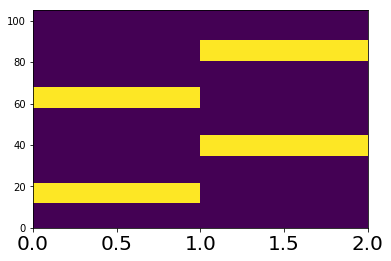

In [127]:
# create a boolean array denoting the timing for different music conditions
onsets_negative_music = np.asarray(events.onset[events['trial_type'] == 'negative_music'])
onsets_positive_music = np.asarray(events.onset[events['trial_type'] == 'positive_music'])

music = np.zeros((n_scans, nr_cond))
for i in range(len(music)):
    if i in onsets_negative_music/tr:
        for k in range(int(epoch_duration/tr)):
            music[i + k, 0] = 1
    if i in onsets_positive_music/tr:
        for k in range(int(epoch_duration/tr)):
            music[i + k, 1] = 1
            
music = music.astype(bool) 
plt.pcolormesh(music)
plt.show()

In [11]:
# apply smoothing to the data
from nilearn import image 
func_data_sm = [] # initialize a list to put smoothed data
for n in range(nr_sub):
    func_data_sm.append(image.smooth_img(func_data[n], fwhm=8))

In [12]:
# define some model parameters
drift_model = None
period_cut = 3. * epoch_duration
hrf_model = 'glover + derivative' #can also try spm, glover

# define the model
from nistats.first_level_model import FirstLevelModel
fmri_glm = FirstLevelModel(tr, noise_model='ar1',
                           standardize=False, hrf_model=hrf_model,
                           drift_model=drift_model, period_cut=period_cut)

fmri_glm = fmri_glm.fit(func_data_sm, events_allsub, confounds=motion_conf_all)

C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nistats\first_level_model.py:465: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  labels, results = mem_glm(Y, design.as_matrix(),


In [128]:
from nistats.reporting import plot_design_matrix
design_matrix = fmri_glm.design_matrices_[0]

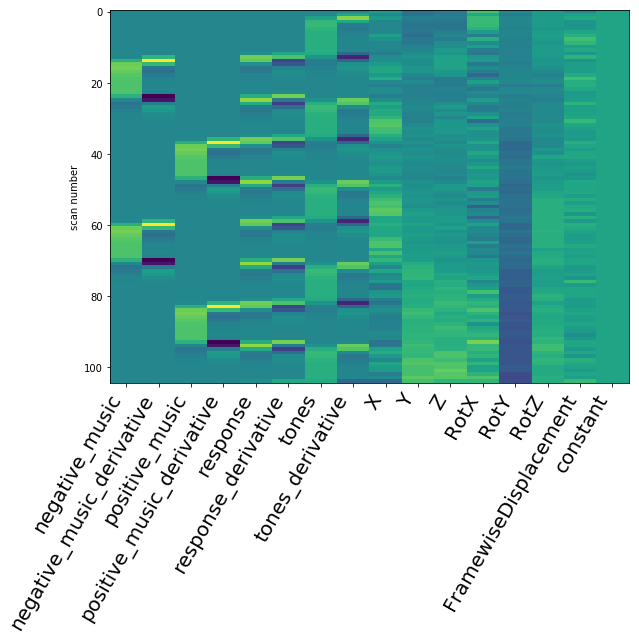

In [129]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,9))
plot_design_matrix(design_matrix, ax=ax)

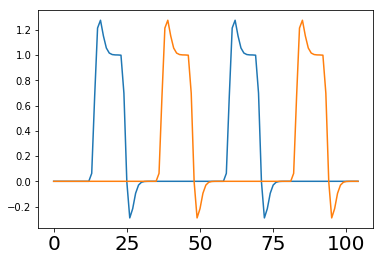

In [130]:
# contrast matrix
contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(design_matrix.columns)])
import matplotlib.pyplot as plt
design_matrix = design_matrix.reset_index()
plt.plot(design_matrix['negative_music'])
plt.plot(design_matrix['positive_music'])

# Negative Music 

C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nistats\first_level_model.py:539: UserWarning: One contrast given, assuming it for all 21 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


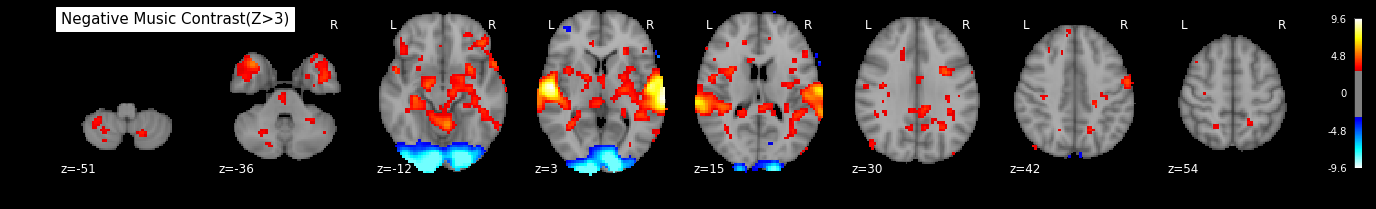

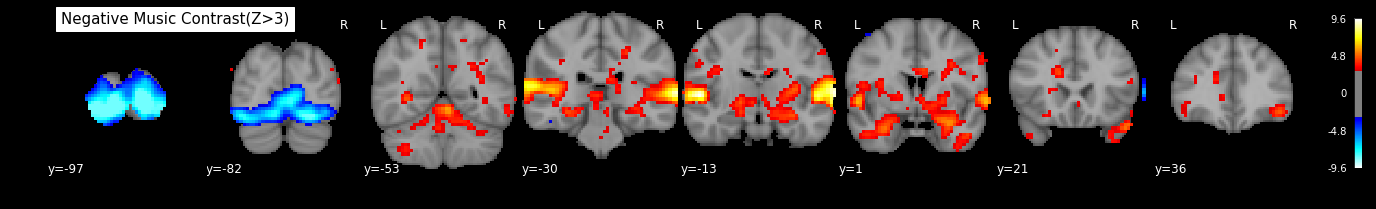

In [133]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
z_map_negative_music = fmri_glm.compute_contrast('negative_music', output_type='z_score')

plot_stat_map(z_map_negative_music, threshold=3.0,
              display_mode='z', cut_coords=8, black_bg=True,
              title='Negative Music Contrast(Z>3)')
plot_stat_map(z_map_negative_music, threshold=3.0,
              display_mode='y', cut_coords=8, black_bg=True,
              title='Negative Music Contrast(Z>3)')

# Positive music

C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nistats\first_level_model.py:539: UserWarning: One contrast given, assuming it for all 21 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nistats\first_level_model.py:539: UserWarning: One contrast given, assuming it for all 21 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


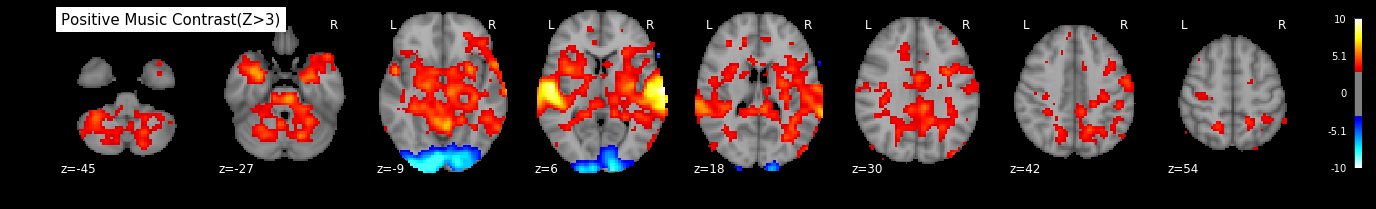

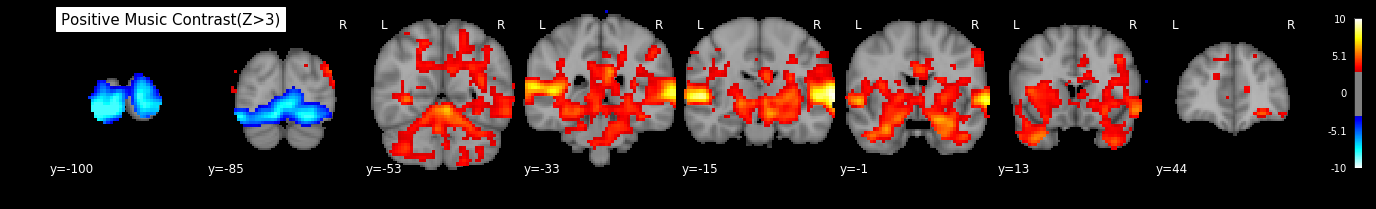

In [134]:
z_map_positive_music = fmri_glm.compute_contrast('positive_music', output_type='z_score')
p_map_positive_music = fmri_glm.compute_contrast('positive_music', output_type='p_value')

plot_stat_map(z_map_positive_music, threshold=3,
              display_mode='z', cut_coords=8, black_bg=True,
              title='Positive Music Contrast(Z>3)')
plot_stat_map(z_map_positive_music, threshold=3,
              display_mode='y', cut_coords=8, black_bg=True,
              title='Positive Music Contrast(Z>3)')


# Positive Music vs Negative Music

C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nistats\first_level_model.py:539: UserWarning: One contrast given, assuming it for all 21 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


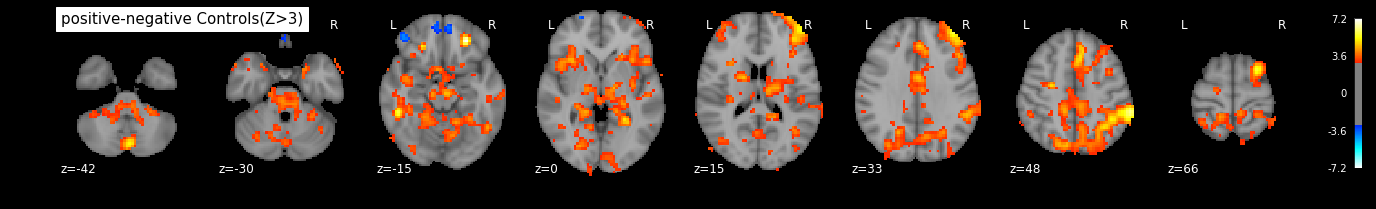

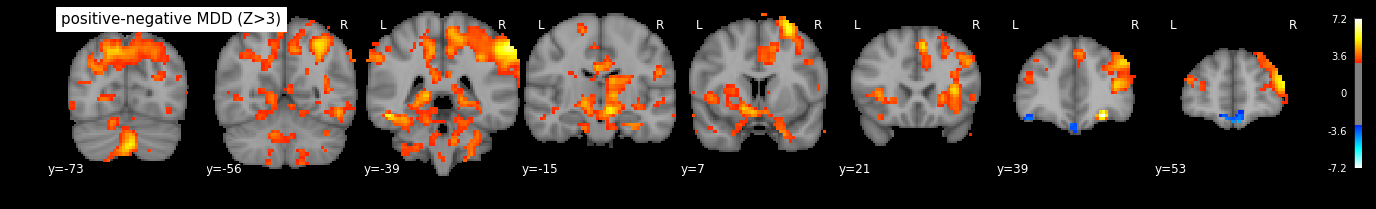

In [15]:
pos_minus_neg_music = contrasts['positive_music'] - contrasts['negative_music']
z_map_pos_minus_neg = fmri_glm.compute_contrast(pos_minus_neg_music, output_type='z_score')

plot_stat_map(z_map_pos_minus_neg, threshold=3.0,
              display_mode='z', cut_coords=8, black_bg=True,
              title='positive-negative Controls(Z>3)')
plot_stat_map(z_map_pos_minus_neg, threshold=3,
              display_mode='y', cut_coords=8, black_bg=True,
              title='positive-negative MDD (Z>3)')

# Extract signal from voxels

In [136]:
# Find the coordinates of the peaks from negative and positive music using clustering
from nistats.thresholding import get_clusters_table

coords = get_clusters_table(z_map_negative_music, stat_threshold=5, cluster_threshold=0)
negative_music_coords = pd.DataFrame(coords, columns=['X', 'Y', 'Z'])
print(negative_music_coords.shape)

coords = get_clusters_table(z_map_positive_music, stat_threshold=6, cluster_threshold=0)
positive_music_coords = pd.DataFrame(coords, columns=['X', 'Y', 'Z'])
print(positive_music_coords.shape)

ccl = np.vstack([negative_music_coords, positive_music_coords]) # combined_coord_list
ccl

(12, 3)
(12, 3)


array([[-55, -13,   3],
       [-35,  13, -36],
       [-29, -25, -15],
       [-29,   1, -27],
       [  3, -54,  -9],
       [ 20,  -1, -18],
       [ 29,  10,  -9],
       [ 35, -10,   9],
       [ 46,  22, -27],
       [ 69, -25,   3],
       [ 58,  13,  -9],
       [ 69, -16,  -9],
       [-55, -10,   3],
       [-35,   4, -27],
       [-29,   1, -27],
       [-18, -13,  -3],
       [ -9, -48, -12],
       [  3, -57,  -9],
       [  6, -25, -27],
       [  8, -19, -12],
       [ 20,  -1, -18],
       [ 32,   1, -21],
       [ 35, -10,   9],
       [ 69, -13,   6]], dtype=int64)

[[-55 -13   3]
 [-35  13 -36]
 [-29 -25 -15]
 [-29   1 -27]
 [  3 -54  -9]
 [ 20  -1 -18]
 [ 29  10  -9]
 [ 35 -10   9]
 [ 46  22 -27]
 [ 69 -25   3]
 [ 58  13  -9]
 [ 69 -16  -9]
 [-35   4 -27]
 [-18 -13  -3]
 [ -9 -48 -12]
 [  6 -25 -27]
 [  8 -19 -12]
 [ 32   1 -21]
 [ 69 -13   6]]


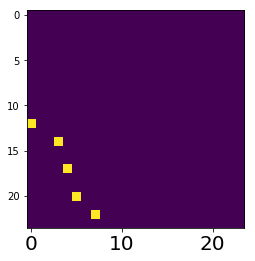

In [137]:
# Use Nearest Neighbors to deal with overlap
import matplotlib.pyplot as plt
from sklearn import neighbors

# Estimate neighbors
clf = neighbors.NearestNeighbors(radius=3)

# Compute neighborhood matrix
A = clf.fit(ccl).radius_neighbors_graph().toarray()
A = np.tril(A, 0)

# Plot lower triangle of neighborhood matrix
plt.imshow(A)

# Select coordinates to keep
selector = A.sum(axis=1) == 0

# Create final object
ccl_final =ccl[selector]
print(ccl_final)

# Extract the signal for one subject

In [138]:
from nilearn.input_data import NiftiSpheresMasker
mask = NiftiSpheresMasker(ccl_final, radius=3,
                          detrend=True, standardize=True,
                          high_pass=None, low_pass=None,
                          t_r=tr, 
                          allow_overlap=False)
sig = mask.fit_transform(func_data_sm[2])
sig.shape

(105, 19)

No handles with labels found to put in legend.


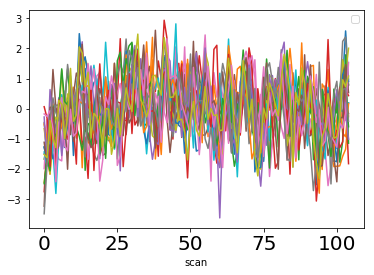

In [139]:
# check if the signal extraction is fine for only one subject
plt.plot(sig)#, label='voxel %d %d %d' % tuple(coord_mm))
plt.xlabel('scan')
plt.legend()
plt.show()

In [140]:
# Create a timeseries object with the extracted signal from all subjects and all coordinates
timeseries = []
for func_img, confound in zip(func_data_sm, motion_conf_all):
    confound = np.array(confound)
    signal = mask.fit_transform(func_img, confounds=confound)
    timeseries.append(signal)

In [153]:
# separate the timeseries object for controls and mdd
np.shape(timeseries) # 21, 105, 19
timeseries = np.asarray(timeseries)
ts_cont = timeseries[0:nr_cont_gp, :, :]
ts_mdd = timeseries[nr_cont_gp:, :, :]

In [141]:
from nilearn.connectome import ConnectivityMeasure
corr_measure_cont = ConnectivityMeasure(kind = 'correlation')
corr_mat_cont = corr_measure_cont.fit_transform(ts_cont)

corr_measure_mdd = ConnectivityMeasure(kind = 'correlation')
corr_mat_mdd = corr_measure_mdd.fit_transform(ts_mdd)

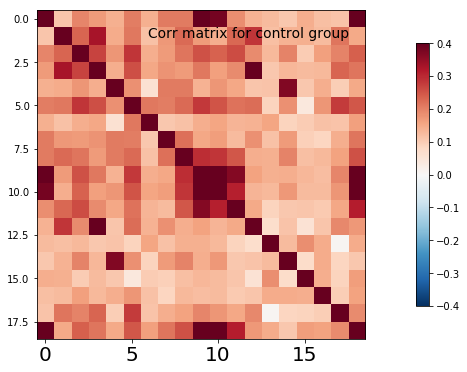

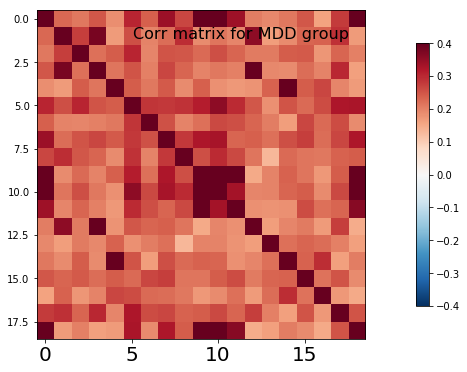

In [146]:
plotting.plot_matrix(corr_measure_cont.mean_, vmin=-0.4, vmax=0.4, title='Corr matrix for control group')
plotting.plot_matrix(corr_measure_mdd.mean_, vmin=-0.4, vmax=0.4, title='Corr matrix for MDD group')

# Get the timeseries specific for each condition and group

In [147]:
# for controls
ts_cont_neg_music = ts_cont[:, music[:, 0], :]
ts_cont_pos_music = ts_cont[:, music[:, 1], :]

# for MDD
ts_mdd_neg_music = ts_mdd[:, music[:, 0], :]
ts_mdd_pos_music = ts_mdd[:, music[:, 1], :]

In [156]:
# corr matrix for controls
nr_rois = timeseries.shape[2]
corr_mat_cont = np.zeros((nr_cont_gp, nr_cond, nr_rois, nr_rois))

for sub in range(nr_cont_gp): 
    # get the condition specific signal from each sub
    neg_music = ts_cont_neg_music[sub, :, :]
    pos_music = ts_cont_pos_music[sub, :, :]
    
    corr_measure = ConnectivityMeasure(kind='correlation')

    fc_neg_music = corr_measure.fit_transform([neg_music])[0]
    np.fill_diagonal(fc_neg_music, 0)
        
    fc_pos_music = corr_measure.fit_transform([pos_music])[0]
    np.fill_diagonal(fc_pos_music, 0)
        
    corr_mat_cont[sub, 0, :, :] = fc_neg_music
    corr_mat_cont[sub, 1, :, :] = fc_pos_music


corr_mat_cont.shape

(11, 2, 19, 19)

In [157]:
# corr matrix for mdd
corr_mat_mdd = np.zeros((nr_mdd_gp, nr_cond, nr_rois, nr_rois))
corr_mat_mdd.shape

for sub in range(nr_mdd_gp): 
    # get the condition specific signal from each sub
    neg_music = ts_mdd_neg_music[sub, :, :]
    pos_music = ts_mdd_pos_music[sub, :, :]
    
    corr_measure = ConnectivityMeasure(kind='correlation')

    fc_neg_music = corr_measure.fit_transform([neg_music])[0]
    np.fill_diagonal(fc_neg_music, 0)
        
    fc_pos_music = corr_measure.fit_transform([pos_music])[0]
    np.fill_diagonal(fc_pos_music, 0)
        
    corr_mat_mdd[sub, 0, :, :] = fc_neg_music
    corr_mat_mdd[sub, 1, :, :] = fc_pos_music


corr_mat_mdd.shape


(10, 2, 19, 19)

In [158]:
# get the mean across subjects
cont_neg_music_mean = corr_mat_cont[:, 0, :, :].mean(axis = 0)
cont_pos_music_mean = corr_mat_cont[:, 1, :, :].mean(axis = 0)

mdd_neg_music_mean = corr_mat_mdd[:, 0, :, :].mean(axis = 0)
mdd_pos_music_mean = corr_mat_mdd[:, 1, :, :].mean(axis = 0)

# For controls

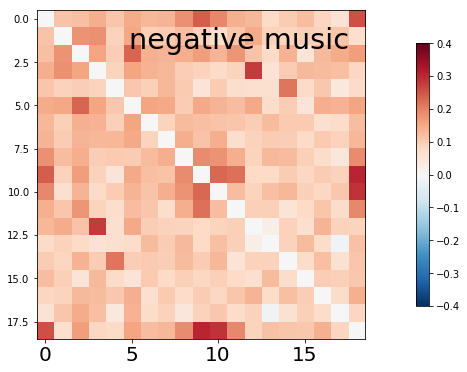

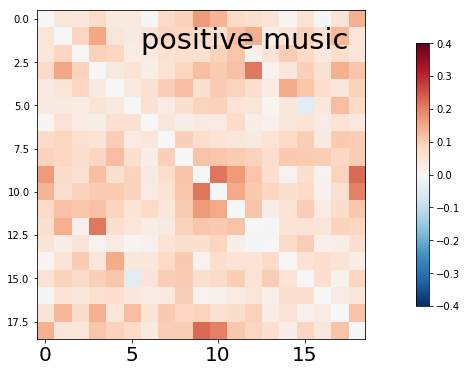

In [161]:
# mean connectivity matrix for control group for negative and positive music conditions
plotting.plot_matrix(cont_neg_music_mean, vmin=-0.4, vmax=0.4, title='negative music')
plotting.plot_matrix(cont_pos_music_mean, vmin=-0.4, vmax=0.4, title='positive music')

# For Depression Patients

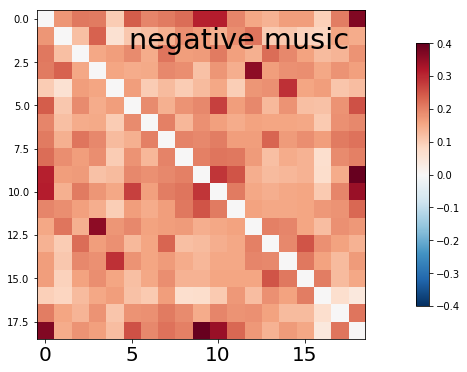

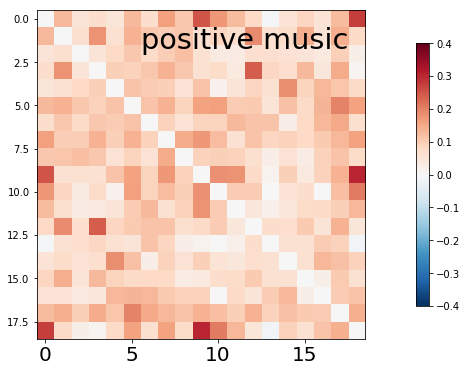

In [163]:
plotting.plot_matrix(mdd_neg_music_mean, vmin=-0.4, vmax=0.4, title='negative music')
plotting.plot_matrix(mdd_pos_music_mean, vmin=-0.4, vmax=0.4, title='positive music')

In [164]:
# do some stats
from scipy import stats
from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix

cont_neg_music = sym_matrix_to_vec(corr_mat_cont[:, 0, :, :], discard_diagonal = True)
cont_pos_music = sym_matrix_to_vec(corr_mat_cont[:, 1, :, :], discard_diagonal = True)
mdd_neg_music = sym_matrix_to_vec(corr_mat_mdd[:, 0, :, :], discard_diagonal = True)
mdd_pos_music = sym_matrix_to_vec(corr_mat_mdd[:, 1, :, :], discard_diagonal = True)

In [165]:
# t test comparisons
# between groups
#stat, pvalues = stats.ttest_ind(cont_neg_music, mdd_neg_music)
#stat, pvalues = stats.ttest_ind(cont_pos_music, mdd_pos_music)

# within groups
stat, pvalues = stats.ttest_rel(mdd_neg_music, mdd_pos_music)
#stat, pvalues = stats.ttest_rel(cont_neg_music, cont_pos_music)

In [166]:
import statsmodels.stats.multitest as ssm

_, pvals_corrected, _, _ = ssm.multipletests(pvalues, alpha = 0.05, method = 'fdr_bh')

pvals_corrected_thr = np.zeros((len(pvals_corrected)))
pvals = np.array([0 if p >= 0.08 else 1 for p in pvals_corrected])

wei_vector = stat * pvals 
diag = np.zeros((nr_rois))
matrix = vec_to_sym_matrix(pvals_corrected)
matrix_wei = vec_to_sym_matrix(wei_vector, diagonal = diag)
matrix_bin = vec_to_sym_matrix(pvals, diagonal = diag)

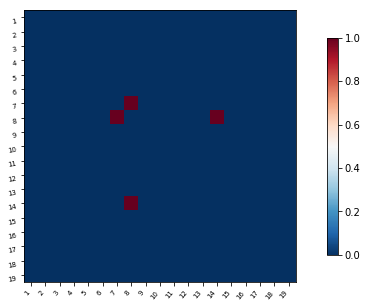

In [168]:
plotting.plot_matrix(matrix_bin, labels=np.arange(1, nr_rois+1))

# Create glass brain visualization

In [106]:
# visualization of our ROIs in the MNI template
view = plotting.view_markers(ccl, marker_size=5)
view


C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nilearn\plotting\js_plotting_utils.py:97: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than 10 '


# Found increased connectivity bw Insula and Putamen and bw Insula and Temporal Pole when depressed patients were listening to Negative Music than Positive Music

In [171]:
ind_sig_corr = np.array([ccl[6], ccl[7], ccl[13]])
view = plotting.view_markers(ind_sig_corr, colors=['r', 'g', 'b'], marker_size=8)
view

C:\Users\ilkay\Miniconda2\envs\py36\lib\site-packages\nilearn\plotting\js_plotting_utils.py:97: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than 10 '


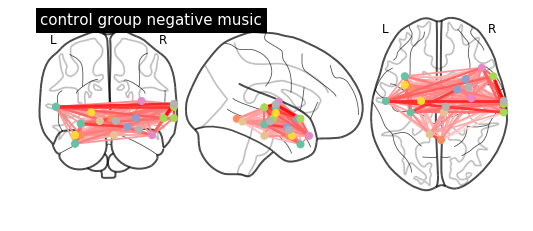

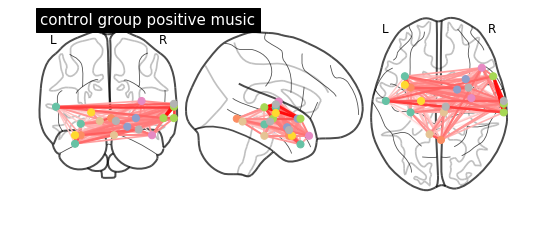

In [45]:
# Visualize the correlations in glass brains
# Negative music for control group
plotting.plot_connectome(cont_neg_music_mean, ccl_final, title='control group negative music')
# Postive music for control group
plotting.plot_connectome(cont_pos_music_mean, ccl_final, title='control group positive music')

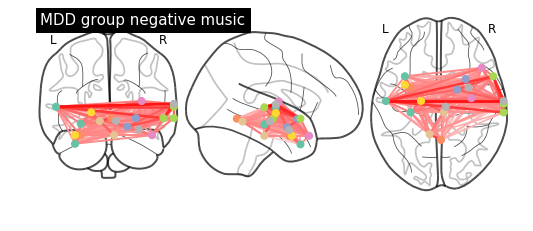

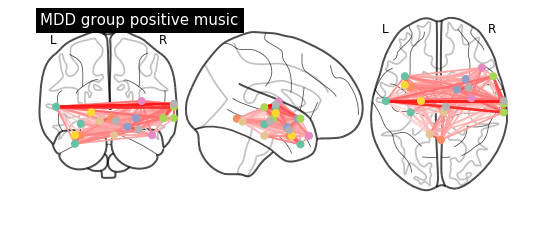

In [46]:
# Negative music for mdd group
plotting.plot_connectome(mdd_neg_music_mean, ccl_final, title='MDD group negative music')
# Postive music for mdd group
plotting.plot_connectome(mdd_pos_music_mean, ccl_final, title='MDD group positive music')